# 0.0 Overview plots

In [1]:
prefix = '/home/ines/repositories/'
# prefix = '/Users/ineslaranjeira/Documents/Repositories/'

In [2]:

""" 
IMPORTS
"""
import os
import numpy as np
import seaborn as sns
import pandas as pd
import pickle

from one.api import ONE
import matplotlib.pyplot as plt


# Get my functions
functions_path = prefix + '/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from preprocessing_functions import idxs_from_files
functions_path =  prefix + '/representation_learning_variability/Models/Sub-trial//3_postprocess_results/'
os.chdir(functions_path)
from postprocessing_functions import remove_states_str, state_identifiability, align_bin_design_matrix, states_per_trial_phase, broader_label
os.chdir(functions_path)
from plotting_functions import plot_avg_state, wheel_over_wavelet_clusters, plot_states_aligned
functions_path =  prefix + '/representation_learning_variability/Functions/'
os.chdir(functions_path)
from data_processing import save_and_log
one = ONE(mode='remote')

## Parameters

In [7]:
# Parameters
bin_size = 0.017
multiplier = 1
num_states = 2
num_iters = 100
threshold = 0.05
sticky = False
optimal_k = 4
num_train_batches = 20

event_type_list = ['goCueTrigger_times']  # , 'feedback_times', 'firstMovement_times'
event_type_name = ['Go cue']  # , 'Feedback time', 'First movement onset'

save_path = '/home/ines/repositories/representation_learning_variability/Exported figures/COSYNE/'

# LOAD DATA
data_path ='/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v5_15Jan2025/' + str(bin_size) + '/'
all_files = os.listdir(data_path)
design_matrices = [item for item in all_files if 'design_matrix' in item and 'standardized' not in item]
idxs, mouse_names = idxs_from_files(design_matrices, bin_size)

states_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/' + str(bin_size) + '/'+str(num_states)+'_states/most_likely_states/'+ 'v5_15Jan2025/'
wavelet_states_path = '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/'  + str(bin_size) + '/wavelet_transform_states/'


use_sets = [['avg_wheel_vel', '0.5', '1.0', '2.0', '4.0', '8.0'], ['whisker_me'], ['Lick count']]
var_interest_map = ['wavelet', 'whisker_me', 'Lick count']

idx_init_list = [4, 1, 3]
idx_end_list = [9, 2, 4]

path_sets = [wavelet_states_path, states_path, states_path]

# Did this on the 28th February!!!!! dataset from a week before was scrambled
identifiable_mapping = {'000': 0.0,
           '100': 1.0,
           '200': 2.0,
           '300': 3.0,
           '010': 4.0,
           '110': 5.0,
           '210': 6.0,
           '310': 7.0,
           '001': 8.0,
           '101': 9.0,
           '201': 10.0,
           '301': 11.0, 
           '011': 12.0,
           '111': 13.0,
           '211': 14.0,
           '311': 15.0,
           'nan': np.nan
           }
inverted_mapping = {v: k for k, v in identifiable_mapping.items()}
wheel_mapping = {1:0, 2:1, 3:2, 0:3}

# Individual sessions

In [8]:
# Identify sessions available to process
sessions_to_process = []
for m, mat in enumerate(idxs):
    mouse_name = mat[37:]
    session = mat[:36]
    fit_id = str(mouse_name + session)
    whisker_filename = os.path.join(states_path, "most_likely_states" + 'whisker_me' + '_' + fit_id)
    licks_filename = os.path.join(states_path, "most_likely_states" + 'Lick count' + '_' + fit_id)
    wavelet_filename = os.path.join(wavelet_states_path, "most_likely_states_" + str(optimal_k) + '_' + fit_id)

    if os.path.exists(whisker_filename) and os.path.exists(licks_filename) and os.path.exists(wavelet_filename):
        sessions_to_process.append((mouse_name, session))

print(f"Found {len(sessions_to_process)} sessions to process.")

Found 215 sessions to process.


In [9]:
# Load preprocessed data
results_path = '/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/'
filename_states = str(results_path + 'states_trial_type03-11-2025')
states_file = pd.read_parquet(filename_states, engine='pyarrow')

## Plot variables separately

In [10]:
def wheel_over_wavelet_clusters(init, inter, empirical_data, var_to_plot, session_trials, vlines=False):
    # Plot raw trace over states
    # init should be in seconds; inter should be in frames
    frame_rate = 60

    fig, ax = plt.subplots(ncols=1 , nrows=1, sharex=False, sharey=False, figsize=[12, 4])
    plt.rc('font', size=20)
    
    if var_to_plot == 'avg_wheel_vel':
        ylabel = "Wheel velocity (rad/s)"
        state_ticks = [0., 1., 2., 3.]
        tick_labels = ['Wheel 0', 'Wheel 1', 'Wheel 2', 'Wheel 3']
        plot_min = -6
        plot_max = 6
        ax.set_xticks(np.arange(init, init+inter, inter/5), [])
        ax.set_xlabel('')
    elif var_to_plot == 'whisker_me':
        ylabel = "Whisker motion energy"
        state_ticks = [0., 1.]
        tick_labels = ['No whisking', 'Whisking']
        plot_min = -2
        plot_max = 5
        ax.set_xticks(np.arange(init, init+inter, inter/5), [])
        ax.set_xlabel('')
    elif var_to_plot=='Lick count':
        ylabel = 'Lick count'
        state_ticks = [0., 1.]
        tick_labels = ['No licking', 'Licking']
        plot_min = 0
        plot_max = 3
        ax.set_yticks([0, 1, 2] ,[0, 1, 2])
        ax.set_xticks(np.arange(init, init+inter, inter/5), np.round(np.arange(init/frame_rate, 
                  (init+inter)/frame_rate, (inter/frame_rate)/5), 1))
        ax.set_xlabel("Time (s)")


    colormap = 'Greys'
    
    ax.plot(empirical_data.loc[empirical_data['Bin']>=init, var_to_plot].reset_index(), color='black')
    sts = ax.imshow(np.concatenate([empirical_data.loc[empirical_data['Bin']>=init, 'most_likely_states']])[None,:],
                extent=(0, len(np.concatenate([empirical_data.loc[empirical_data['Bin']>=init, 'most_likely_states']])), plot_min, plot_max),
                aspect="auto",
                cmap=colormap,
                alpha=0.3)
    cbar = fig.colorbar(sts, ax=ax, ticks=state_ticks)
    cbar.ax.set_yticklabels(tick_labels)  # vertically oriented colorbar
    if vlines:
        ax.vlines(np.array(session_trials['goCueTrigger_times'] -init)*frame_rate, plot_min, plot_max, label='Stim On', 
                    color='Black', linewidth=2)
        ax.vlines(np.array(session_trials.loc[session_trials['feedbackType']==1, 'feedback_times'] * frame_rate)-init*frame_rate, 
                    plot_min, plot_max, label='Correct', color='Green', linewidth=2)
        ax.vlines(np.array(session_trials.loc[session_trials['feedbackType']==-1, 'feedback_times'] * frame_rate)-init*frame_rate, 
                    plot_min, plot_max, label='Incorrect', color='Red', linewidth=2)
        ax.vlines(np.array(session_trials['firstMovement_times'] * frame_rate)-init*frame_rate, plot_min, plot_max, label='First movement', color='Blue')
        ax.vlines(np.array(session_trials['intervals_0'] * frame_rate)-init*frame_rate, plot_min, plot_max, label='Trial end', color='Grey', linewidth=2)
        ax.vlines(np.array((session_trials['goCueTrigger_times'] - session_trials['quiescencePeriod']) * frame_rate)-init*frame_rate, 
                    plot_min, plot_max, label='Quiescence start', color='Pink', linewidth=2)

    ax.set_xlim([init, init+inter])
    ax.set_ylabel(ylabel)
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax.set_ylim([plot_min, plot_max])

    plt.tight_layout()    
    plt.savefig(save_path+'_'+var_to_plot+'over_states.svg', format="svg")
    plt.show()
    
    
from matplotlib.colors import ListedColormap, to_rgb, to_hex

def create_grouped_gradient_palette(n_groups=4, shades_per_group=4, base_palette='tab10'):
    # Pick n_groups distinct colors from base palette
    base_colors = sns.color_palette(base_palette, n_colors=n_groups)
    
    # Function to generate shades for a given color
    def generate_shades(color, n_shades):
        color_rgb = np.array(to_rgb(color))
        # Create shades by interpolating towards white (lighter) or black (darker)
        factors = np.linspace(0.4, 1.0, n_shades)  # You can adjust range for more/less contrast
        return [to_hex(color_rgb * factor + (1 - factor)) for factor in factors]
    
    # Build full palette
    full_palette = []
    for color in base_colors:
        shades = generate_shades(color, shades_per_group)
        full_palette.extend(shades)
    
    return ListedColormap(full_palette)


def plot_states_aligned_trial(trial_init, use_data, session_trials, trials_to_plot, inverted_mapping):
    
    fig, axs = plt.subplots(nrows=trials_to_plot, ncols=1, sharex=True, sharey=True, figsize=[8, 6])
    plt.rc('font', size=12)
    
    frame_rate = 60
    pre_stim = 1
    post_stim = 1.5
    average_window_size = (pre_stim + post_stim) * frame_rate
    palette_16 = create_grouped_gradient_palette(n_groups=4, shades_per_group=4, base_palette='tab10')
    stimOns = list(use_data['goCueTrigger_times'].drop_duplicates())

    for t in range(trials_to_plot):
        
        stimOn = stimOns[t]
        trial_init = stimOn - pre_stim
        bin_data = use_data.loc[(use_data['Bin']<(stimOn + post_stim)) & (use_data['Bin']> (stimOn - pre_stim))]
        trial_data = session_trials.loc[(session_trials['goCueTrigger_times']< (stimOn+2)) & 
                                        (session_trials['goCueTrigger_times']> (stimOn-2))]
        # Hacky solution to make sure color palette is used properly
        attach_array1 = np.arange(0, len(use_data['most_likely_states'].unique()), 1)
        attach_array = np.concatenate([np.arange(0, 10, 1)*np.nan, attach_array1])
        cax = axs[t].imshow(
            np.concatenate([bin_data['most_likely_states'], attach_array])[None,:], 
            extent=(0, len(np.concatenate([bin_data['most_likely_states'], attach_array])), -1, 1),
            aspect="auto",
            cmap=palette_16,
            alpha=0.5) 
        
        axs[t].vlines((stimOn-trial_init)* frame_rate,-1, 1, color='Black', linewidth=2)
        axs[t].vlines(np.array(trial_data.loc[trial_data['feedbackType']==1, 'feedback_times']-trial_init)* frame_rate,
                      -1, 1, label='Correct', color='Black', linewidth=2, linestyle=':')
        axs[t].vlines(np.array(trial_data.loc[trial_data['feedbackType']==-1, 'feedback_times']-trial_init)* frame_rate,
                      -1, 1, label='Incorrect', color='Black', linewidth=2, linestyle='--')
        # axs[t].vlines(np.array(trial_data['firstMovement_times']-trial_init)* frame_rate, -1, 1, 
        #               label='First movement', color='Blue')
        axs[t].vlines(np.array((trial_data['goCueTrigger_times'] - trial_data['quiescencePeriod'])-trial_init)* frame_rate,
                      -1, 1, label='Quiescence start', color='Black', linestyle='-.', linewidth=2)
    
    
    cbar = fig.colorbar(cax, ax=axs)
    cbar.set_label('Syllable')
    cbar.ax.invert_yaxis()
    if len(inverted_mapping) > 0:
        # Set the ticks and labels based on the dictionary
        cbar.set_ticks(list(inverted_mapping.keys()))
        cbar.set_ticklabels(list(inverted_mapping.values()))
        
    axs[t].set_yticks([] ,[])
    axs[t].set_xticks([0, (stimOn-trial_init)* frame_rate, (stimOn-trial_init+post_stim)* frame_rate] ,[-1, 0, 1.5])
    axs[t].set_xlabel(str('Time from stimulus onset (s)'))
    axs[t].set_xlim([0, average_window_size+1])

    axs[t].legend(loc='upper left', bbox_to_anchor=(1.4, 0))
    plt.savefig(save_path+'trial_stack.svg', format="svg")
    plt.show()

/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:554: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  trials['prev_choice'][1:] = trials['choice'][:-1]
/home/ines/repositories/representation_learni

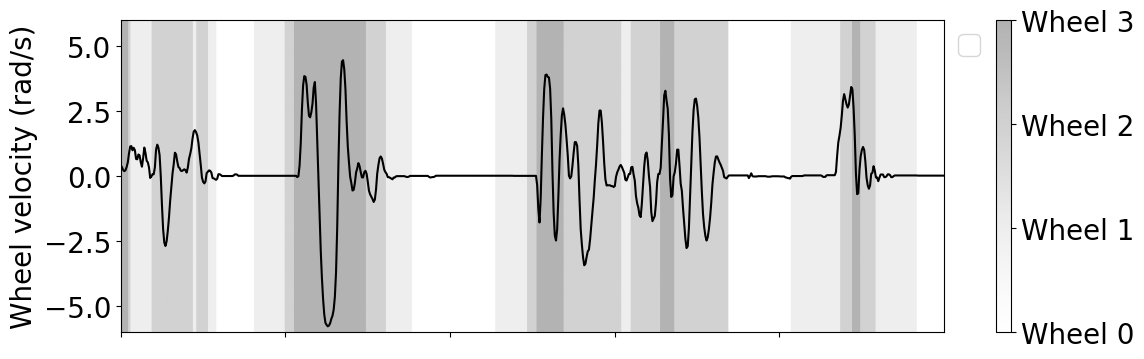

/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:554: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  trials['prev_choice'][1:] = trials['choice'][:-1]
/home/ines/repositories/representation_learni

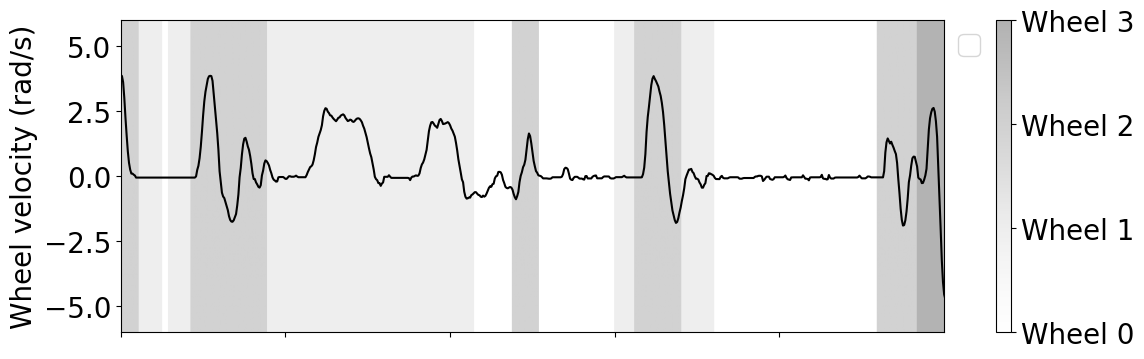

/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:554: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  trials['prev_choice'][1:] = trials['choice'][:-1]
/home/ines/repositories/representation_learni

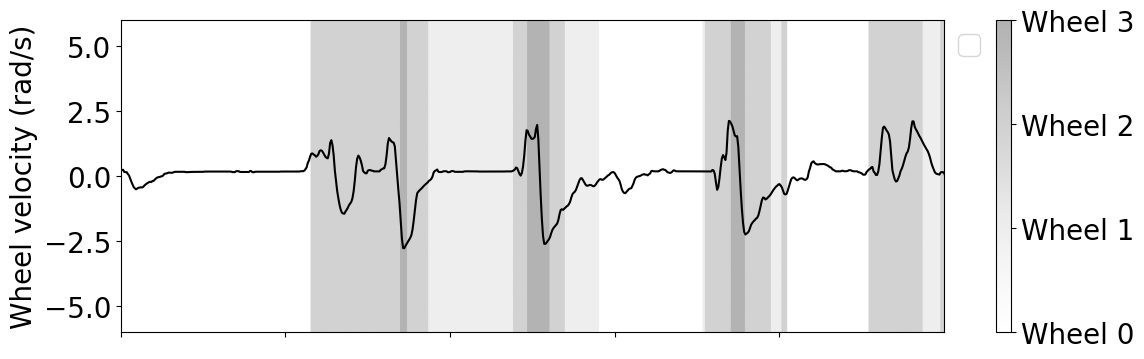

/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:554: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  trials['prev_choice'][1:] = trials['choice'][:-1]
/home/ines/repositories/representation_learni

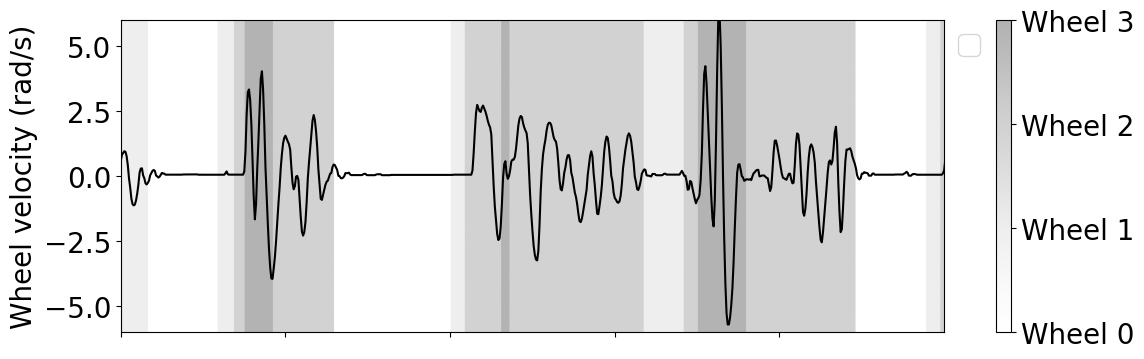

/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:554: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  trials['prev_choice'][1:] = trials['choice'][:-1]
/home/ines/repositories/representation_learni

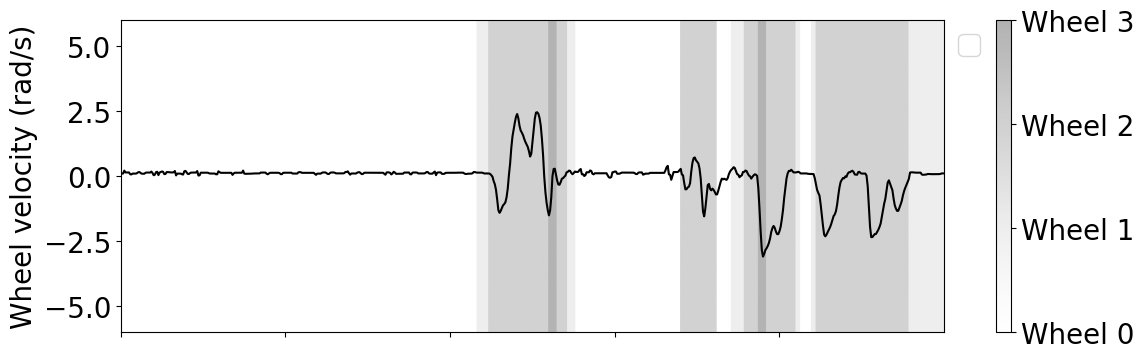

/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:554: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  trials['prev_choice'][1:] = trials['choice'][:-1]
/home/ines/repositories/representation_learni

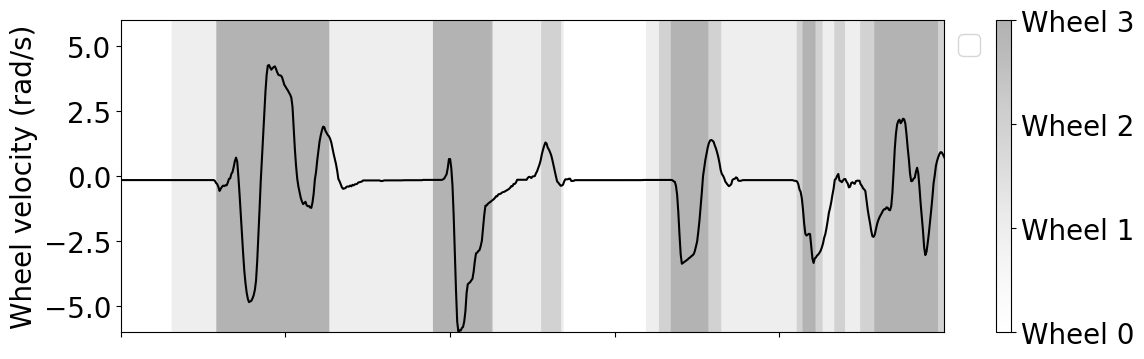

/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:554: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  trials['prev_choice'][1:] = trials['choice'][:-1]
/home/ines/repositories/representation_learni

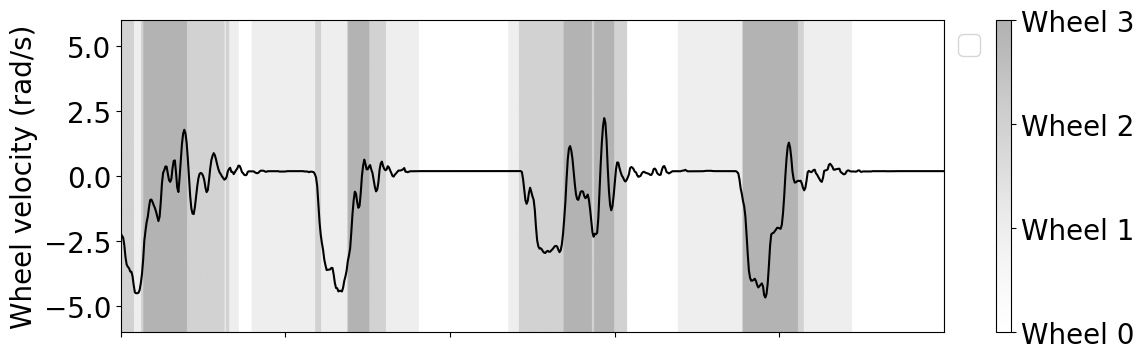

/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:554: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  trials['prev_choice'][1:] = trials['choice'][:-1]
/home/ines/repositories/representation_learni

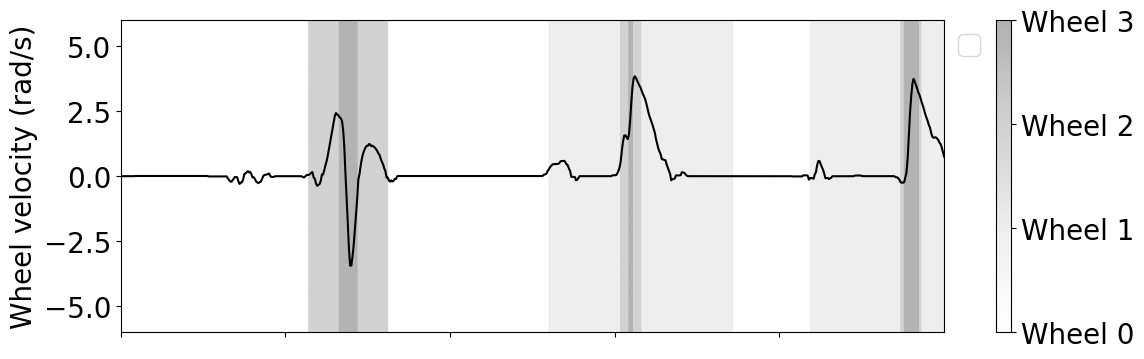

/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:554: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  trials['prev_choice'][1:] = trials['choice'][:-1]
/home/ines/repositories/representation_learni

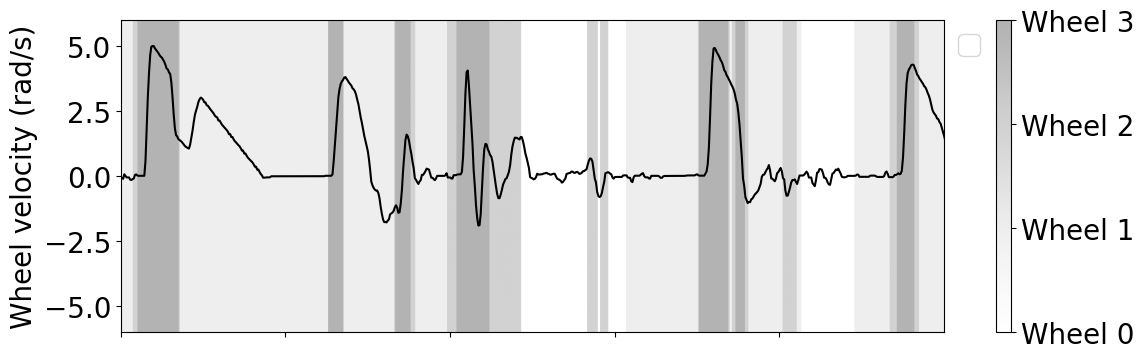

/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:554: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  trials['prev_choice'][1:] = trials['choice'][:-1]
/home/ines/repositories/representation_learni

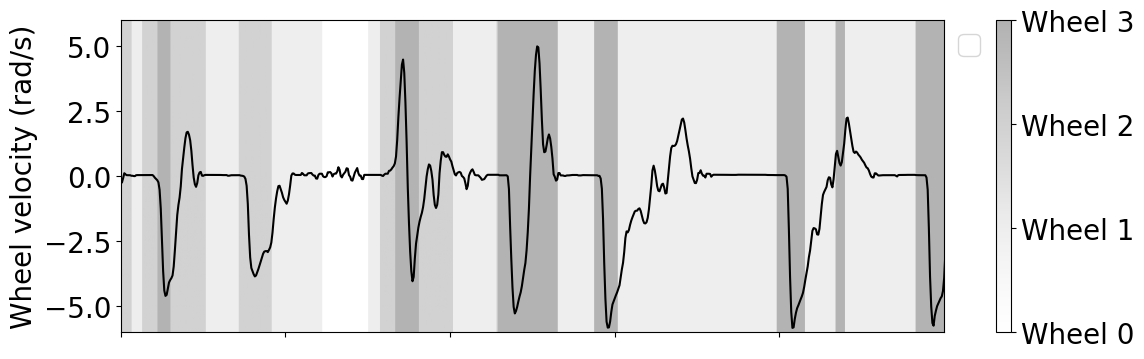

In [16]:
var_interest = 'whisker_me'
var_interest = 'wavelet'
index_var = np.where(np.array(var_interest_map)==var_interest)[0][0]
idx_init = idx_init_list[index_var]
idx_end = idx_end_list[index_var]
var_names = use_sets[index_var]

for m, mat in enumerate(sessions_to_process[:10]):


    mouse_name = mat[0]
    session = mat[1]
    # mouse_name = 'CSHL054'
    # session = 'a71175be-d1fd-47a3-aa93-b830ea3634a1'
    
    fit_id = str(mouse_name+session)

    # Get session data
    filename = data_path + "session_trials_" + str(session) + '_'  + mouse_name
    session_trials = pd.read_parquet(filename, engine='pyarrow').reset_index()  # I think resetting index is what gives the trial number?
    # Get design_matrix
    filename = data_path + "design_matrix_" + str(session) + '_'  + mouse_name
    unnorm_design_matrix =  pd.read_parquet(filename, engine='pyarrow').dropna().reset_index()
    # Get session data
    filename = data_path + "standardized_design_matrix_" + str(session) + '_'  + mouse_name
    standardized_designmatrix = np.load(filename+str('.npy'))
    filtered_matrix = standardized_designmatrix[~np.isnan(standardized_designmatrix).any(axis=1)]  # Need to dropnans
    # design_matrix = np.abs(filtered_matrix.copy()[:, idx_init:idx_end])
    design_matrix = filtered_matrix.copy()[:, idx_init:idx_end]
    num_timesteps = np.shape(design_matrix)[0]
    mat_length = np.min([(num_timesteps // 5) * 5, (num_timesteps // 20) * 20])  # To account for different lengths
    data = design_matrix[:mat_length]

    """ Load states """
    # Save most_likely_states
    use_path = path_sets[index_var]
    states_filename = os.path.join(use_path, "most_likely_states" + f"{'_'+str(optimal_k) if var_interest=='wavelet' else var_interest}"+ '_' + fit_id)
    if var_interest == 'wavelet':
        most_likely_states = pickle.load(open(states_filename, "rb"))[:mat_length]
        replace_wheel = np.vectorize(wheel_mapping.get)
        most_likely_states = replace_wheel(most_likely_states)
    else:
        most_likely_states, _, _ = pickle.load(open(states_filename, "rb"))[:mat_length]

    " Prepare data "

    num_timesteps = np.shape(design_matrix)[0]
    if var_interest == 'wavelet':
        design_matrix_heading = pd.DataFrame(columns=var_names[1:])
        design_matrix_heading[var_names[1:]] = design_matrix[0:len(most_likely_states)]  # TODO: need to understand why number is the same and whether it depends on lag
    else:
        design_matrix_heading = pd.DataFrame(columns=var_names)
        design_matrix_heading[var_names] = design_matrix[0:len(most_likely_states)]
    bins = unnorm_design_matrix['Bin']  # [:mat_length]
    design_matrix_heading['Bin'] = bins
    design_matrix_heading['avg_wheel_vel'] = filtered_matrix[:len(data), 0]  #filtered_matrix[:len(data), 0]
    design_matrix_heading['Lick count'] = unnorm_design_matrix[:len(most_likely_states)]['Lick count']
    
    # Align bins
    init = -1 * multiplier
    end = 1.5 * multiplier
    empirical_data = align_bin_design_matrix(init, end, event_type_list, session_trials, design_matrix_heading, most_likely_states, multiplier)

    # # Plot raw trace over states       
    init = 500
    inter = 700
    plot_var = 'avg_wheel_vel' if var_interest == 'wavelet' else var_interest
    wheel_over_wavelet_clusters(init, inter, empirical_data, plot_var, session_trials, vlines=False)
    
    # Plot trials stacked
    mouse_df = states_file.loc[states_file['session']==session]
    use_data = mouse_df.merge(empirical_data[['trial_id', 'Bin', 'new_bin']], on='Bin')
    
    # trial_init=5
    # trials_to_plot = 20
    # plot_states_aligned_trial(trial_init, use_data, session_trials, trials_to_plot, inverted_mapping)


/tmp/ipykernel_6118/1772724026.py:61: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper left', bbox_to_anchor=(1, 1))


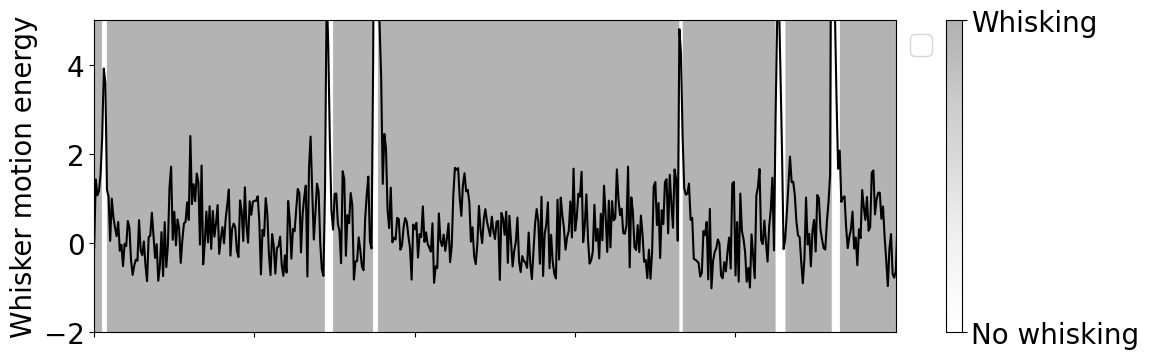

In [24]:

# # Plot raw trace over states       
init = 4000
inter = 500
plot_var = 'avg_wheel_vel' if var_interest == 'wavelet' else var_interest
wheel_over_wavelet_clusters(init, inter, empirical_data, plot_var, session_trials, vlines=False)


In [15]:
def wheel_over_wavelet_clusters(init, inter, empirical_data):
    # Plot raw trace over states
    # init should be in seconds; inter should be in frames
    frame_rate = 60
    plot_min = -5
    plot_max=5
    fig, ax = plt.subplots(ncols=1 , nrows=1, sharex=False, sharey=False, figsize=[12, 4])
    plt.rc('font', size=16)

    colormap = create_grouped_gradient_palette(n_groups=4, shades_per_group=4, base_palette='tab10')
    
    ax.plot(empirical_data.loc[empirical_data['Bin']>=init, 'avg_wheel_vel'].reset_index(), color='black', linestyle='--',linewidth=1)
    ax.plot(empirical_data.loc[empirical_data['Bin']>=init, 'whisker_me'].reset_index(), color='black',  linewidth=1)
    ax.plot(empirical_data.loc[empirical_data['Bin']>=init, 'Lick count'].reset_index(), color='black', linestyle='dashdot',linewidth=1)
    cax = ax.imshow(np.concatenate([empirical_data.loc[empirical_data['Bin']>=init, 'most_likely_states']])[None,:],
                extent=(0, len(np.concatenate([empirical_data.loc[empirical_data['Bin']>=init, 'most_likely_states']])), plot_min, plot_max),
                aspect="auto",
                cmap=colormap,
                alpha=0.5)
    cbar = fig.colorbar(cax, ax=ax)
    cbar.set_label('Syllable')
    cbar.ax.invert_yaxis()
    if len(inverted_mapping) > 0:
        # Set the ticks and labels based on the dictionary
        cbar.set_ticks(list(inverted_mapping.keys()))
        cbar.set_ticklabels(list(inverted_mapping.values()))

    ax.set_xlim([init, init+inter])
    ax.set_ylabel('')
    ax.set_xlabel("Time (s)")
    ax.set_xticks(np.arange(init, init+inter, inter/5), np.round(np.arange(init/frame_rate, 
                  (init+inter)/frame_rate, (inter/frame_rate)/5), 1))
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax.set_ylim([plot_min, plot_max])

    plt.tight_layout()    
    plt.savefig(save_path+'conjunction_states_raw.svg', format="svg")

    plt.show()

/tmp/ipykernel_12470/1389717414.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper left', bbox_to_anchor=(1, 1))


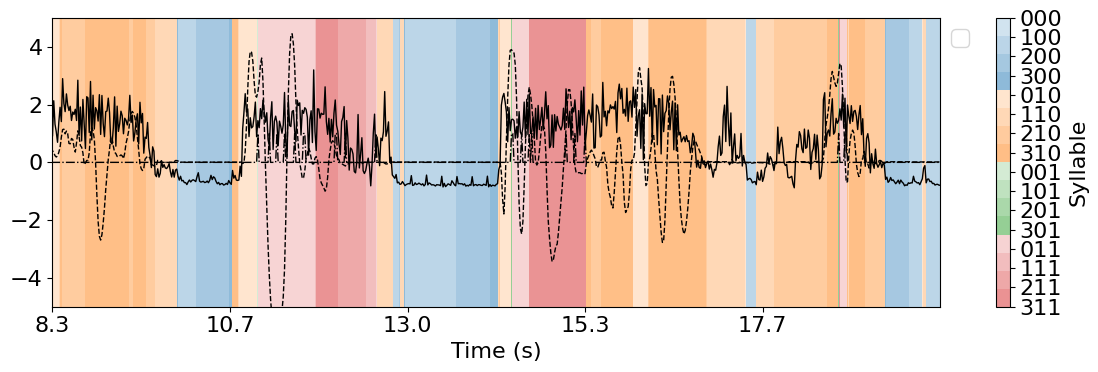

In [37]:
init = 500
inter = 700
wheel_over_wavelet_clusters(init, inter, use_data, session_trials, vlines=False)

In [56]:
def plot_raw_trace(init, inter, empirical_data, var_to_plot):
    # Plot raw trace over states
    # init should be in seconds; inter should be in frames
    frame_rate = 60
    plot_min = -10
    plot_max=10
    fig, ax = plt.subplots(ncols=1 , nrows=3, sharex=True, sharey=False, figsize=[12, 8])
    plt.rc('font', size=16)

    
    ax[0].plot(empirical_data.loc[empirical_data['Bin']>=init, var_to_plot[0]].reset_index(), color='black', linewidth=2)
    ax[1].plot(empirical_data.loc[empirical_data['Bin']>=init, var_to_plot[1]].reset_index(), color='black', linewidth=2)
    ax[2].plot(empirical_data.loc[empirical_data['Bin']>=init, var_to_plot[2]].reset_index(), color='black', linewidth=2)

    ax[0].set_xlim([init, init+inter])
    ax[0].set_ylabel('')
    ax[0].set_xlabel("")
    ax[0].set_xticks([], [])
    ax[0].set_ylim([-6, 6])
    ax[1].set_ylim([-2, 4])
    ax[2].set_ylim([-1, 3])
    plt.tight_layout()    
    # plt.savefig(save_path+'conjunction_states_raw.svg', format="svg")

    plt.show()

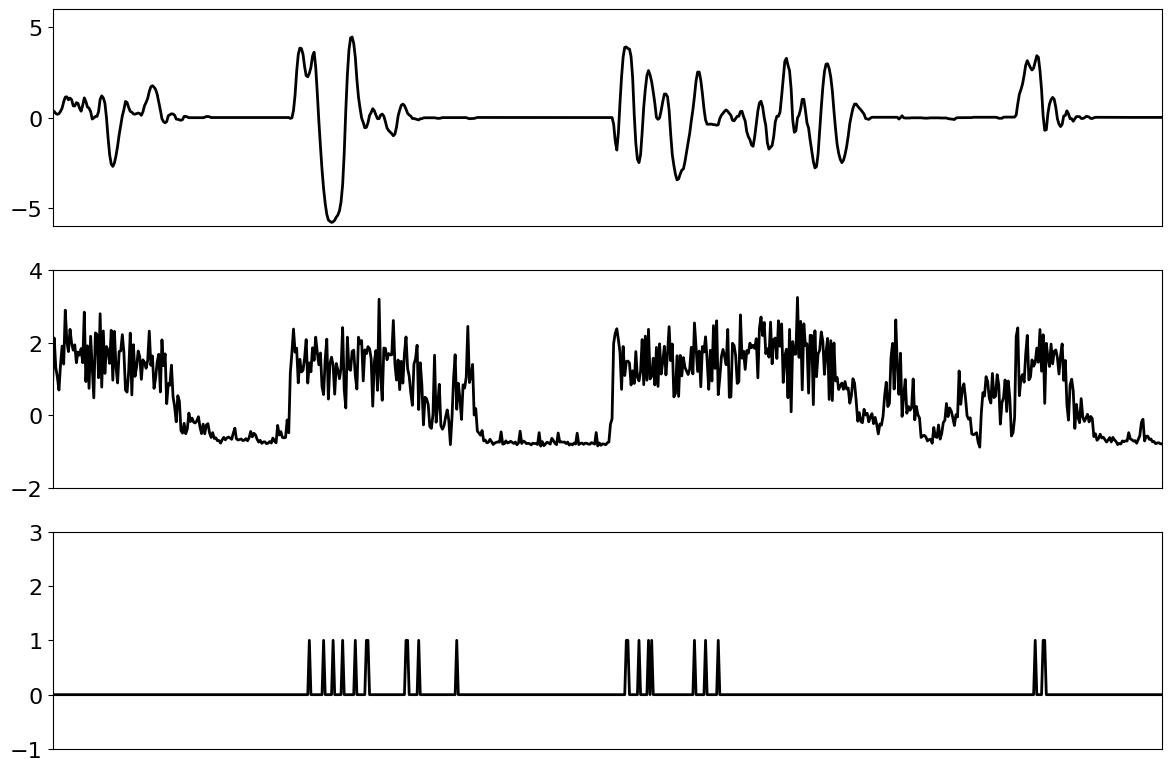

In [57]:
init = 500
inter = 700
plot_raw_trace(init, inter, use_data, ['avg_wheel_vel', 'whisker_me', 'Lick count'])

In [58]:
def wheel_over_wavelet_clusters(init, inter, empirical_data):
    # Plot raw trace over states
    # init should be in seconds; inter should be in frames
    frame_rate = 60
    plot_min = -5
    plot_max=5
    fig, ax = plt.subplots(ncols=1 , nrows=1, sharex=False, sharey=False, figsize=[12, 4])
    plt.rc('font', size=16)

    colormap = create_grouped_gradient_palette(n_groups=4, shades_per_group=4, base_palette='tab10')
    cax = ax.imshow(np.concatenate([empirical_data.loc[empirical_data['Bin']>=init, 'most_likely_states']])[None,:],
                extent=(0, len(np.concatenate([empirical_data.loc[empirical_data['Bin']>=init, 'most_likely_states']])), plot_min, plot_max),
                aspect="auto",
                cmap=colormap,
                alpha=0.5)
    cbar = fig.colorbar(cax, ax=ax)
    cbar.set_label('Syllable')
    cbar.ax.invert_yaxis()
    if len(inverted_mapping) > 0:
        # Set the ticks and labels based on the dictionary
        cbar.set_ticks(list(inverted_mapping.keys()))
        cbar.set_ticklabels(list(inverted_mapping.values()))

    ax.set_xlim([init, init+inter])
    ax.set_ylabel('')
    ax.set_xlabel("Time (s)")
    ax.set_xticks(np.arange(init, init+inter, inter/5), np.round(np.arange(init/frame_rate, 
                  (init+inter)/frame_rate, (inter/frame_rate)/5), 1))
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax.set_ylim([plot_min, plot_max])

    plt.tight_layout()    
    plt.savefig(save_path+'conjunction_states_raw.svg', format="svg")

    plt.show()

/tmp/ipykernel_12470/3552671467.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper left', bbox_to_anchor=(1, 1))


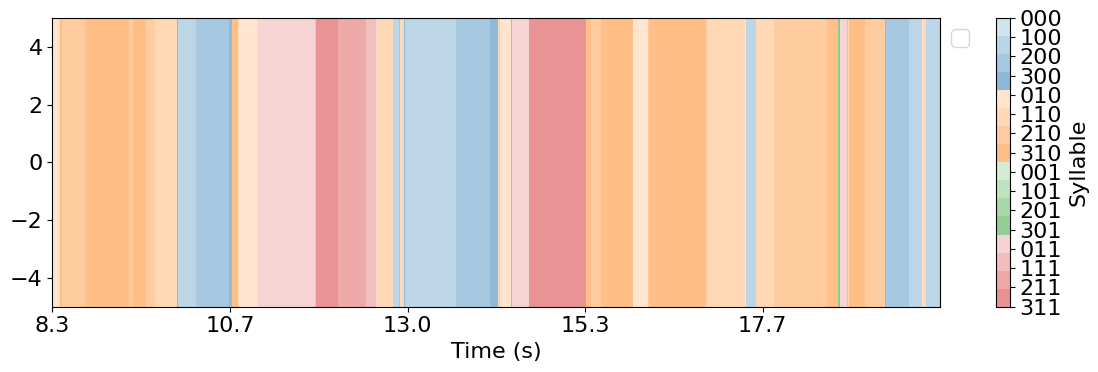

In [60]:
init = 500
inter = 700
wheel_over_wavelet_clusters(init, inter, use_data)

# Histogram

/tmp/ipykernel_13309/1188474834.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper left', bbox_to_anchor=(1.1, 1))


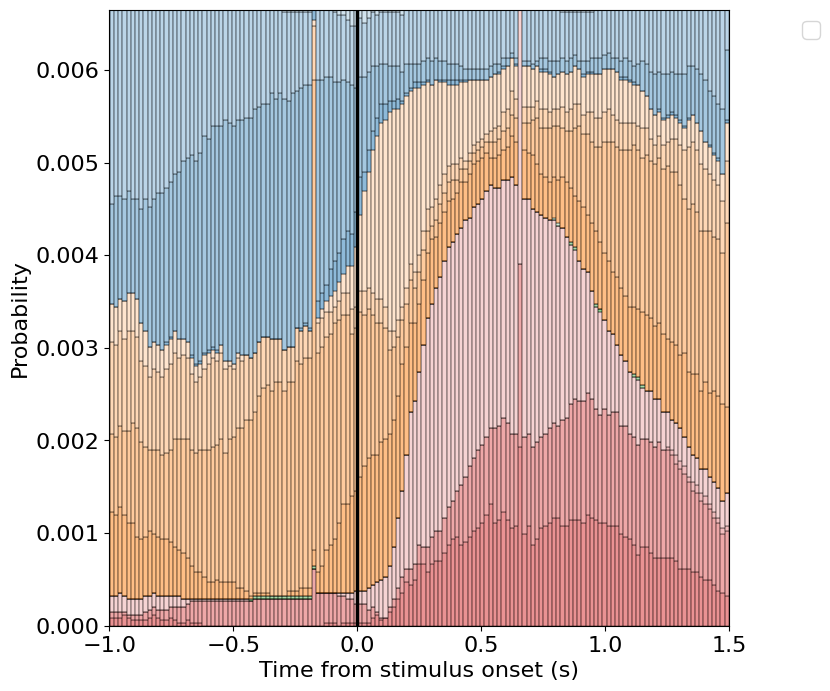

In [12]:
bin_size=.017
palette_16 = create_grouped_gradient_palette(n_groups=4, shades_per_group=4, base_palette='tab10')
palette_16_list = [palette_16(i) for i in range(palette_16.N)]  # Extract colors properly
order = ['000', '100', '200', '300', '010', '110',
           '210', '310', '001', '101', '201', '301', '011',
           '111', '211', '311']
state_to_color = dict(zip(order, palette_16_list))
plt.figure(figsize=[8, 8])
plt.rc('font', size=16)

sns.histplot(x='new_bin', hue='identifiable_states', data=use_data, stat='probability', alpha=0.5, 
                    multiple="stack", legend=True,palette=state_to_color, hue_order=order, binwidth=bin_size)
plt.vlines(0, 0, 1, color='Black', linewidth=2.5)
plt.legend(loc='upper left', bbox_to_anchor=(1.1, 1))
plt.ylim(0, 0.00665)
plt.xlim(-1, 1.5)
plt.xlabel('Time from stimulus onset (s)')
plt.savefig(save_path+'trial_stack_histogram.svg', format="svg")